# Trade-off entre sesgo y varianza, Ensambles, etc.

A lo largo del notebook vamos a trabajar con el siguiente dataset:

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## Trade-off entre sesgo y varianza


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics

1. Abrir el dataset

In [2]:
data = pd.read_csv("weatherAUS.csv")
data.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_MM  \
0       1007.1       8.0       NaN     16.9     21.8         No      0.0   
1       1007.8       NaN       NaN     17.2     24.3         No      0.0   
2       1008.7       NaN       2.0     21.0     23.2         No      0.0   
3       1012.8       NaN       NaN     18.1     26.5         No      1.0   
4       1006.0       7.0       8.0     17.8     29.7         No      0.2   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 24 columns]

Contamos cuántos valores no-nulos hay

In [3]:
data.count().sort_values()

Sunshine          74377
Evaporation       81350
Cloud3pm          85099
Cloud9am          88536
Pressure9am      128179
Pressure3pm      128212
WindDir9am       132180
WindGustDir      132863
WindGustSpeed    132923
WindDir3pm       138415
Humidity3pm      138583
Temp3pm          139467
WindSpeed3pm     139563
Humidity9am      140419
RainToday        140787
Rainfall         140787
WindSpeed9am     140845
Temp9am          141289
MinTemp          141556
MaxTemp          141871
Date             142193
Location         142193
RISK_MM          142193
RainTomorrow     142193
dtype: int64

2. Tirar las columnas que no nos interesan, entre ellas las que tienen pocos datos (menos de cien mil). Además, tirar 'Location' y 'Date', ya que no nos interesa el lugar ni fecha (al menos en este análisis), y 'RISK_MM', porque es un *leak*. Para googlear: ¿qué es un leak?

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/discussion/78316

https://www.kaggle.com/alexisbcook/data-leakage

https://community.datarobot.com/t5/general-blog/what-is-target-leakage-and-how-do-i-avoid-it/ba-p/1973

ID, INDICE DEL DATASET O UN ATRIBUTO QUE DESPUES NO VAS A TENER CUANDO QUIERAS PREDECIR

In [4]:
columnas_descartables = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','RISK_MM','Date']
data = data.drop(columns=columnas_descartables)
data.shape

(142193, 17)

3. Tirar todas las filas que tengan valores nulos.

In [5]:
data = data.dropna()
print(data.shape)
data.head()

(112925, 17)


MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed WindDir9am  \
0     13.4     22.9       0.6           W           44.0          W   
1      7.4     25.1       0.0         WNW           44.0        NNW   
2     12.9     25.7       0.0         WSW           46.0          W   
3      9.2     28.0       0.0          NE           24.0         SE   
4     17.5     32.3       1.0           W           41.0        ENE   

  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0        WNW          20.0          24.0         71.0         22.0   
1        WSW           4.0          22.0         44.0         25.0   
2        WSW          19.0          26.0         38.0         30.0   
3          E          11.0           9.0         45.0         16.0   
4         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm RainToday RainTomorrow  
0       1007.7       1007.1     16.9     21.8        No           No  
1       1010.6       1007.8     17.2     24.3        No           No  
2       1007.6       1008.7     21.0     23.2        No           No  
3       1017.6       1012.8     18.1     26.5        No           No  
4       1010.8       1006.0     17.8     29.7        No           No

4. Para simplificar el preprocesamiento, también tirar todas las columnas que tengan valores categóricos. ¿Por qué no nos molesta tirar 'RainToday'?

In [6]:
columnas_descartables = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']
data = data.drop(columns=columnas_descartables)
data.head()

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     13.4     22.9       0.6           44.0          20.0          24.0   
1      7.4     25.1       0.0           44.0           4.0          22.0   
2     12.9     25.7       0.0           46.0          19.0          26.0   
3      9.2     28.0       0.0           24.0          11.0           9.0   
4     17.5     32.3       1.0           41.0           7.0          20.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
0         71.0         22.0       1007.7       1007.1     16.9     21.8   
1         44.0         25.0       1010.6       1007.8     17.2     24.3   
2         38.0         30.0       1007.6       1008.7     21.0     23.2   
3         45.0         16.0       1017.6       1012.8     18.1     26.5   
4         82.0         33.0       1010.8       1006.0     17.8     29.7   

  RainTomorrow  
0           No  
1           No  
2           No  
3           No  
4           No

5. Realizar un countplot para ver cuántos casos hay de lluvia y no-lluvia.

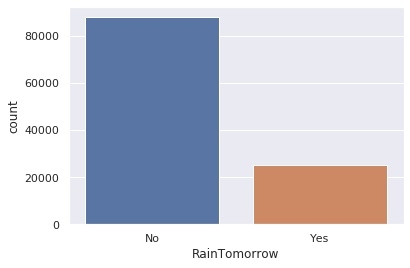

In [7]:
sns.countplot(data.RainTomorrow)
plt.show()

Y hacer el `pairplot` para ver cómo se relacionan las variables. Recuerden que este gráfico puede llevar bastante tiempo.

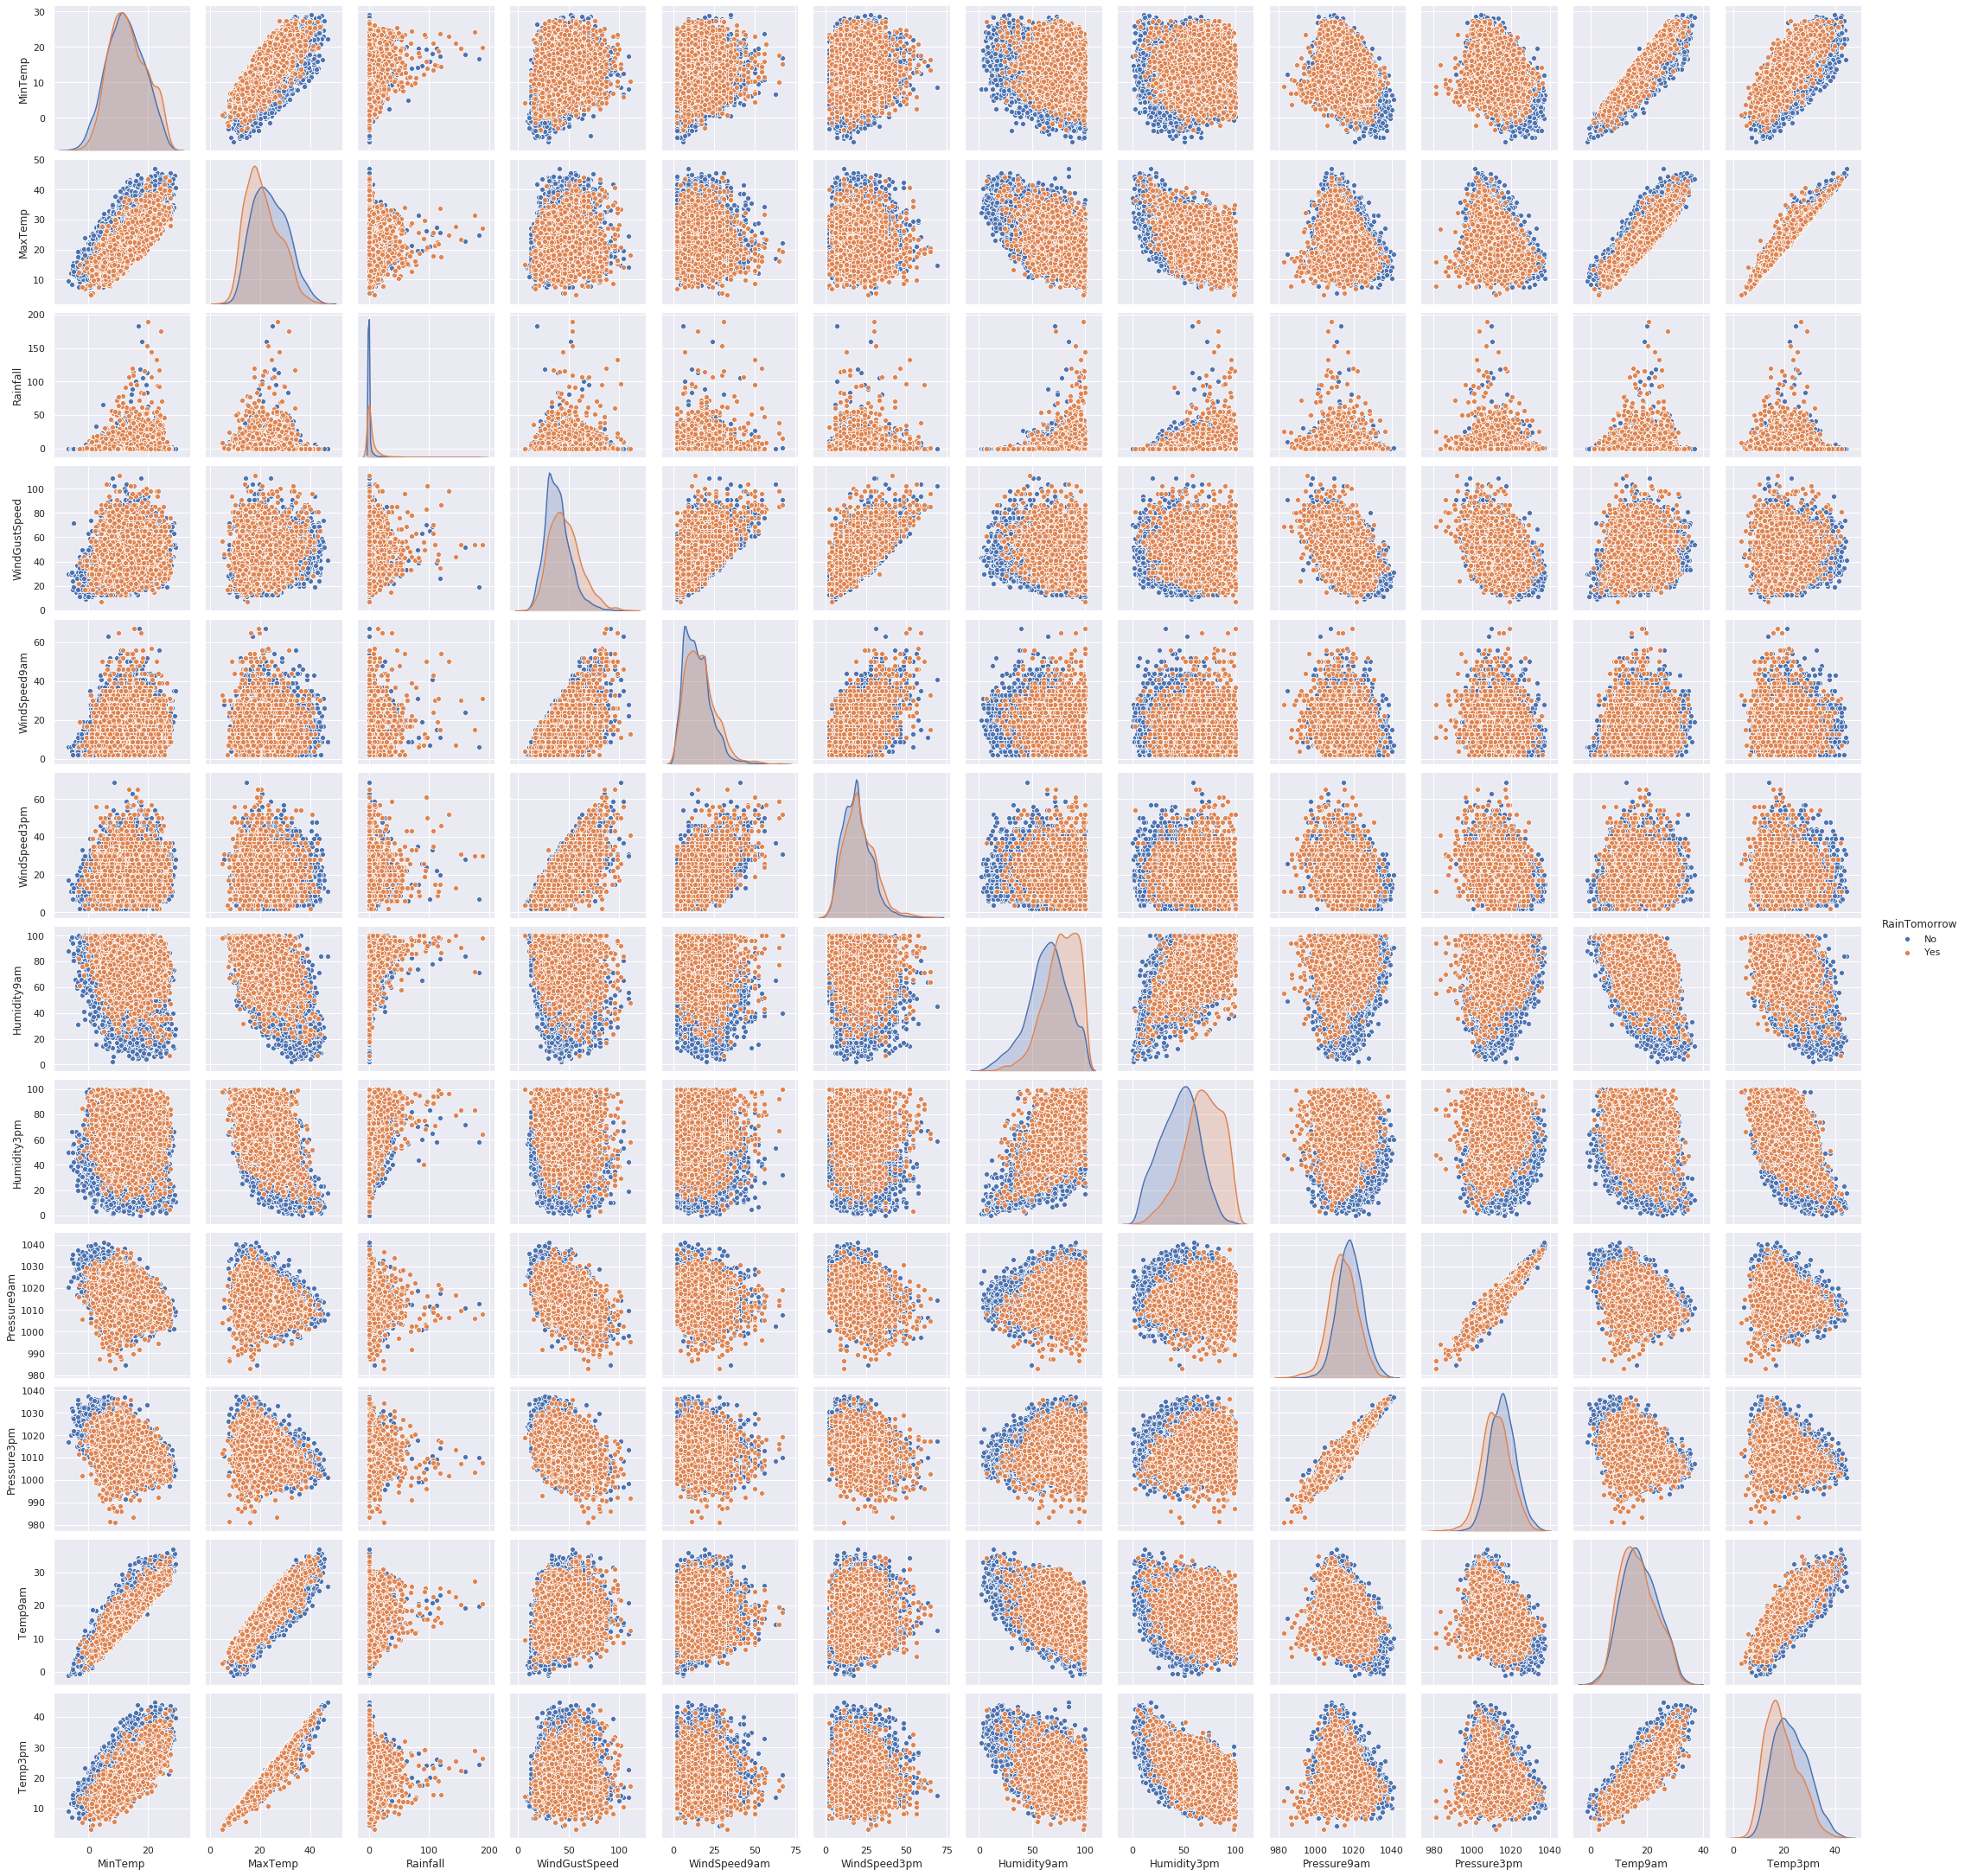

In [8]:
sns.pairplot(data.sample(frac = 0.1), hue = 'RainTomorrow')

Hay algunas que parecen *correlacionadas* (¿Qué significa eso?). Tratamos de cuantificarlo.

In [9]:
data['NuevaVariable'] = data['Rainfall']**3 +3

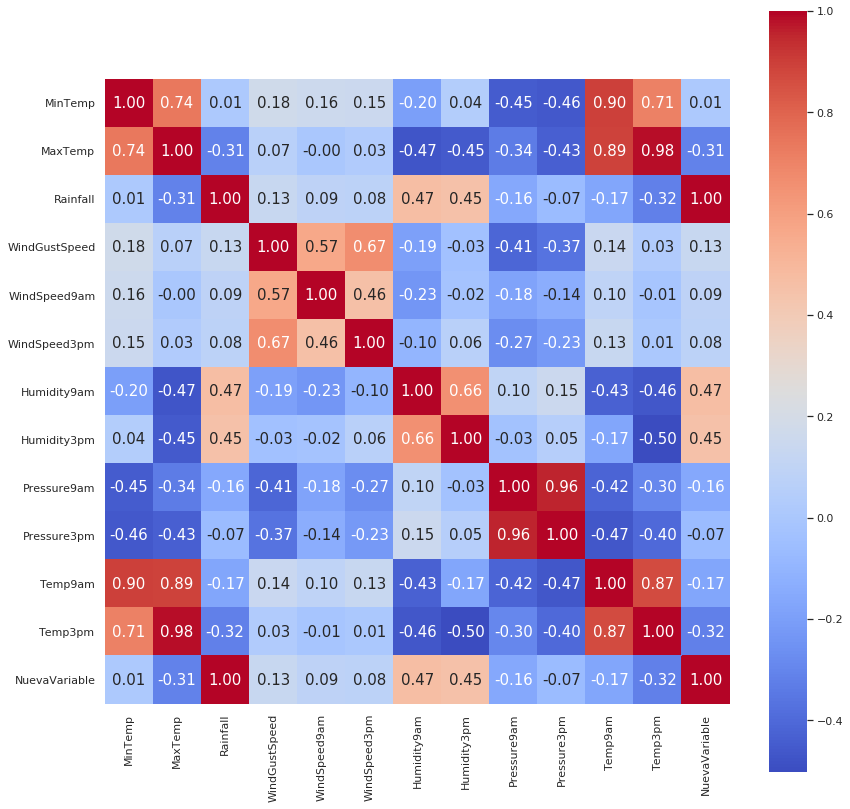

In [10]:
corr = data.drop(columns = ['RainTomorrow']).corr(method='spearman') # .corr is used for find corelation
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data.drop(columns = ['RainTomorrow']).columns, 
           yticklabels= data.drop(columns = ['RainTomorrow']).columns,
           cmap= 'coolwarm')

plt.show()

En base a la correlación, podemos descartar (o no) algunas variables. **Para pensar**, ¿por qué haríamos (o no) esto?

In [11]:
data = data.drop(columns=['Temp3pm', 'Pressure9am', 'NuevaVariable'])
#data = data.drop(columns=['Temp3pm', 'Pressure9am'])

6. Llevar 'RainTomorrow' a una variable númerica

In [12]:
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1,'No':0})
data.head()

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     13.4     22.9       0.6           44.0          20.0          24.0   
1      7.4     25.1       0.0           44.0           4.0          22.0   
2     12.9     25.7       0.0           46.0          19.0          26.0   
3      9.2     28.0       0.0           24.0          11.0           9.0   
4     17.5     32.3       1.0           41.0           7.0          20.0   

   Humidity9am  Humidity3pm  Pressure3pm  Temp9am  RainTomorrow  
0         71.0         22.0       1007.1     16.9             0  
1         44.0         25.0       1007.8     17.2             0  
2         38.0         30.0       1008.7     21.0             0  
3         45.0         16.0       1012.8     18.1             0  
4         82.0         33.0       1006.0     17.8             0

### Datos de entrenamiento y casos *benchmark*

Generamos casos base contra los cuales comparar nuestros resultados.

1. Elegir variables de entrenamiento (empezar con dos) y separar las etiquetas

In [13]:
columnas_entrenamiento = ['MaxTemp', 'Humidity3pm']
X = data[columnas_entrenamiento]
# X = data.drop(columns = 'RainTomorrow')
y = data.RainTomorrow

2. Generar un modelo que diga siempre que NO va a llover y medir su exactitud.

In [14]:
#Todos Ceros
y_pred = np.zeros(y.shape)
accuracy_ceros = metrics.accuracy_score(y,y_pred)
print(accuracy_ceros)

0.7784458711534205


Y generar otro modelo que diga siempre que va a llover y medir su exactitud.

In [15]:
#Todos Unos
y_pred = np.ones(y.shape)
accuracy_unos = metrics.accuracy_score(y,y_pred)
print(accuracy_unos)

0.2215541288465796


3. Generar un modelo que elija al azar si llueve o no

In [16]:
#Todos al azar
n = 20 #Lo hacemos varias veces para tener una idea de la desviacion
accuracy_random = []
for i in range(n):
    y_pred = np.random.randint(2, size=y.size)
    metrics.accuracy_score(y,y_pred)
    accuracy_random.append(metrics.accuracy_score(y,y_pred))

accuracy_random = np.array(accuracy_random)
print(accuracy_random.mean(), '+-', accuracy_random.std())

0.49961036085897714 +- 0.0014272079654175348


## Sesgo y varianza

1. Separar los datos en train/test. ¿Para qué sirve `stratify`?

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify = y)

#### Curva de validación/complejidad

2. Vamos a entrenar distintos modelos de árboles para clasificación, desde poco profundos (profundidad 1) a muy profundos (profundidad 30). Definir las profundidades sobre las cuales iteraremos.

In [18]:
profundidades = range(1,30)

3. Definidir cuatro listas en las que guardaremos los valores medios y desviaciones estándar de los scores que saldran de una validación cruzada.

In [19]:
cv_scores_train_mean = []
cv_scores_train_std = []
cv_scores_test_mean = []
cv_scores_test_std = []

4. Iterar sobre las profundidades. En cada iteración, crear un `DecisionTreeClassifier` para esa profundidad y evaluarlo usando `cross_validate`. Una vez evaluado, agregar a las listas creadas anteriormente las métricas pertinentes.

In [20]:
for max_depth in profundidades:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state = 42)
    scores = cross_validate(clf, X_train, y_train, cv = 10, 
                            scoring = 'accuracy', n_jobs = -1, return_train_score=True)
    
    cv_scores_train_mean.append(scores['train_score'].mean())
    cv_scores_train_std.append(scores['train_score'].std())
    
    cv_scores_test_mean.append(scores['test_score'].mean())
    cv_scores_test_std.append(scores['test_score'].std())
    
### Convertimos las listas en arreglos de numpy para facilitar el trabajo.
cv_scores_train_mean = np.array(cv_scores_train_mean)
cv_scores_train_std = np.array(cv_scores_train_std)
cv_scores_test_mean = np.array(cv_scores_test_mean)
cv_scores_test_std = np.array(cv_scores_test_std)

5. Plotear, con sus barrar de error, los desempeños en el conjunto de train y en el conjunto de test en función de la profundidad del árbol.

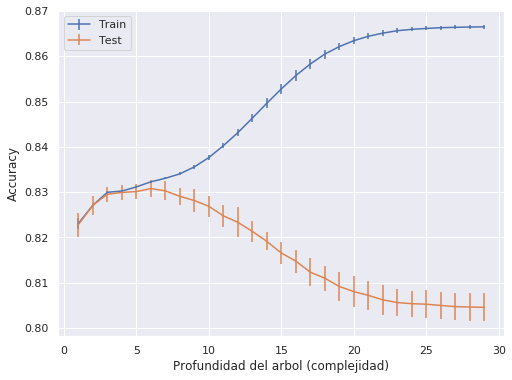

In [21]:
plt.figure(figsize = (8,6))
plt.errorbar(profundidades, cv_scores_train_mean, yerr = cv_scores_train_std , label = 'Train')
plt.errorbar(profundidades, cv_scores_test_mean, yerr = cv_scores_test_std, label = 'Test')
plt.xlabel('Profundidad del arbol (complejidad)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6. Vemos cómo quedan las fronteras para un clasificador sesgado, uno intermedio y uno con alta varianza.

In [22]:
clf_1 = DecisionTreeClassifier(max_depth = 1, random_state=42)
clf_6 = DecisionTreeClassifier(max_depth = 6, random_state=42)
clf_25 = DecisionTreeClassifier(max_depth = 25, random_state=42)

clf_1.fit(X_train,y_train)
clf_6.fit(X_train,y_train)
clf_25.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=25, random_state=42)

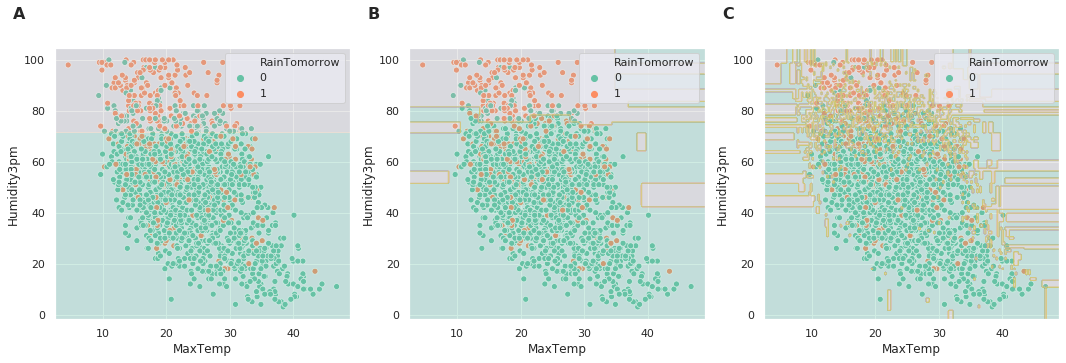

In [23]:
N = 20 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (18,5))

#Grafico Clasificador Sesgado
plt.subplot(1,3,1)
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = clf_1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')
ax.text(-0.1, 1.15, 'A', transform=ax.transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')
   
# Grafico
plt.subplot(1,3,2)
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
Z = clf_6.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')
ax.text(-0.1, 1.15, 'B', transform=ax.transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')
   
#Grafico Clasificador alta varianza
plt.subplot(1,3,3)
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
Z = clf_25.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')
ax.text(-0.1, 1.15, 'C', transform=ax.transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')
    
plt.savefig('overfitting_undefitting.png')
plt.show()

7. Por último, calcular los errores de cada modelo sobre el conjunto de held-out. 

In [24]:
y_test_pred = clf_1.predict(X_test)
print(metrics.accuracy_score(y_test,y_test_pred))

y_test_pred = clf_6.predict(X_test)
print(metrics.accuracy_score(y_test,y_test_pred))

y_test_pred = clf_25.predict(X_test)
print(metrics.accuracy_score(y_test,y_test_pred))

0.8228053604108861
0.8293582856130822
0.8045634334966645


**Ejercicio**: realizar la curva de validación/complejidad, pero en lugar de `accuracy` usar `roc_auc`

In [25]:
### ROC AUC
cv_scores_train_mean = []
cv_scores_train_std = []
cv_scores_test_mean = []
cv_scores_test_std = []

profundidades = range(1,30)
for max_depth in profundidades:
    clf = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_validate(clf, X_train, y_train, cv = 10, scoring = 'roc_auc', n_jobs = -1, return_train_score=True)
    
    cv_scores_train_mean.append(scores['train_score'].mean())
    cv_scores_train_std.append(scores['train_score'].std())
    
    cv_scores_test_mean.append(scores['test_score'].mean())
    cv_scores_test_std.append(scores['test_score'].std())
    
cv_scores_train_mean = np.array(cv_scores_train_mean)
cv_scores_train_std = np.array(cv_scores_train_std)
cv_scores_test_mean = np.array(cv_scores_test_mean)
cv_scores_test_std = np.array(cv_scores_test_std)

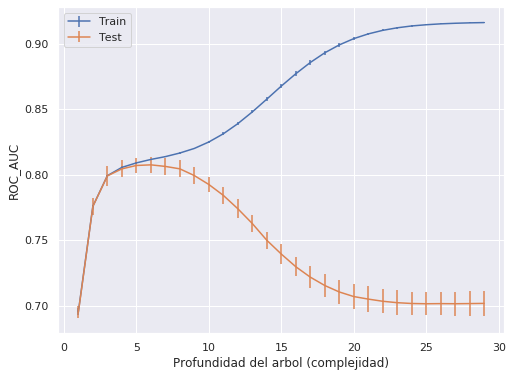

In [26]:
plt.figure(figsize = (8,6))
plt.errorbar(profundidades, cv_scores_train_mean, yerr = cv_scores_train_std , label = 'Train')
plt.errorbar(profundidades, cv_scores_test_mean, yerr = cv_scores_test_std, label = 'Test')
plt.xlabel('Profundidad del arbol (complejidad)')
plt.ylabel('ROC_AUC')
plt.legend()
plt.show()

### Curvas de aprendizaje

Vamos a realizar las curvas de aprendizaje con Scikit-learn

1. Importar de la librería correspondiente `learning_curve`

In [27]:
from sklearn.model_selection import learning_curve

2. Realizar las curvas de complejidad para clf_1, clf_6 y clf_25. Empezar por clf_1

In [28]:
clf_1 = DecisionTreeClassifier(max_depth = 1, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(clf_1, X_train, y_train, 
                                                         train_sizes = np.linspace(0.0001,1,20),
                                                         scoring = 'accuracy', cv=10)

3. Mirar el `shape` de `train_sizes`, `train_scores` y `valid_scores`. ¿En qué `axis` calcularían el promedio y la desviación estándar?

In [29]:
print(train_sizes.shape)
print(train_scores.shape)
print(valid_scores.shape)

(20,)
(20, 10)
(20, 10)


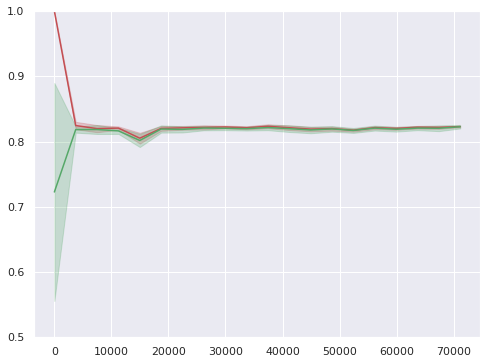

In [30]:
plt.figure(figsize = (8,6))
plt.plot(train_sizes, train_scores.mean(axis = 1), color = 'r')
plt.plot(train_sizes, valid_scores.mean(axis = 1), color = 'g')

plt.fill_between(train_sizes, train_scores.mean(axis = 1)- train_scores.std(axis = 1),
                     train_scores.mean(axis = 1)+ train_scores.std(axis = 1), alpha=0.25,
                     color="r")
plt.fill_between(train_sizes, valid_scores.mean(axis = 1) - valid_scores.std(axis = 1),
                     valid_scores.mean(axis = 1) + valid_scores.std(axis = 1), alpha=0.25, color="g")

plt.ylim(0.5,1)
plt.show()

Y hacemos clf_6 y clf_25

In [31]:
clf_6 = DecisionTreeClassifier(max_depth = 6, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(clf_6, X_train, y_train, 
                                                         train_sizes = np.linspace(0.0001,1,20),
                                                         scoring = 'accuracy', cv=10)

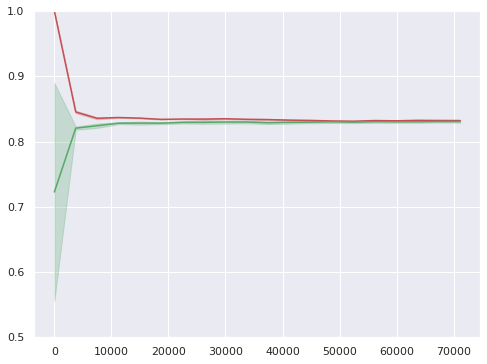

In [32]:
plt.figure(figsize = (8,6))
plt.plot(train_sizes, train_scores.mean(axis = 1), color = 'r')
plt.plot(train_sizes, valid_scores.mean(axis = 1), color = 'g')

plt.fill_between(train_sizes, train_scores.mean(axis = 1)- train_scores.std(axis = 1),
                     train_scores.mean(axis = 1)+ train_scores.std(axis = 1), alpha=0.25,
                     color="r")
plt.fill_between(train_sizes, valid_scores.mean(axis = 1) - valid_scores.std(axis = 1),
                     valid_scores.mean(axis = 1) + valid_scores.std(axis = 1), alpha=0.25, color="g")
plt.ylim(0.5,1)
plt.show()

In [33]:
clf_25 = DecisionTreeClassifier(max_depth = 25, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(clf_25, X_train, y_train, 
                                                         train_sizes = np.linspace(0.0001,1,20),
                                                         scoring = 'accuracy', cv=10)

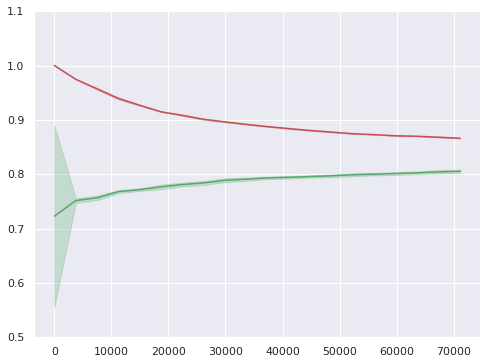

In [34]:
plt.figure(figsize = (8,6))
plt.plot(train_sizes, train_scores.mean(axis = 1), color = 'r')
plt.plot(train_sizes, valid_scores.mean(axis = 1), color = 'g')

plt.fill_between(train_sizes, train_scores.mean(axis = 1)- train_scores.std(axis = 1),
                     train_scores.mean(axis = 1)+ train_scores.std(axis = 1), alpha=0.25,
                     color="r")
plt.fill_between(train_sizes, valid_scores.mean(axis = 1) - valid_scores.std(axis = 1),
                     valid_scores.mean(axis = 1) + valid_scores.std(axis = 1), alpha=0.25, color="g")

plt.ylim(0.5,1.1)
plt.show()

Estudiar las curvas de validación. ¿Se parecen a lo que esperaban?